In [17]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
from Bio import SeqIO
from collections import Counter, defaultdict, OrderedDict
import nltk
from nltk.util import ngrams
import re
from sklearn.linear_model import Lasso, LinearRegression, SGDClassifier, LogisticRegression
import itertools 
import operator
from func_tools import *
reload(func_tools)
%matplotlib inline 

In [83]:
def word_grams(words, min_v=1, max_v=4):
    s = []
    for n in range(min_v, max_v):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

def build_letter_hist(rep, figsize=(5, 5), threshold=0):
    letter_counts = Counter(np.hstack(rep))
    letter_counts_new = drop_rare(letter_counts, threshold=threshold)
    df = pd.DataFrame.from_dict(letter_counts_new, orient='index')
    df.plot(kind='bar', figsize=figsize)

def merge_subarrays(arr):
    return np.hstack(arr)


def drop_rare(counter, threshold=0):
    for k in list(counter):
        if counter[k] < threshold:
            del counter[k]
    return counter


def calculate_prob(words, n=2):
    temp = np.array(list(words))
    result = {}
    for ngram in set(word_grams(words, min_v=n, max_v=n + 1)):
        ngram = ngram.replace(" ", "")
        ngram_positions = [m.start() for m in re.finditer('(?=' + ngram + ')', words)]
        letters_positions = np.array(ngram_positions) + len(ngram)
        letters_position = letters_positions[letters_positions < len(words)]
        counter = dict(Counter(temp[letters_position]))
        total = sum(counter.itervalues(), 0.0)
        counter = {k: 1.0 * v / total for k, v in counter.iteritems()}
        result[ngram] = counter
    return result


def id_to_read(filename):
    inp_seq = SeqIO.parse(filename, "fasta")
    inp_seq = list(inp_seq)
    read_id = [x.id for x in inp_seq]
    inp_reads = [str(x.seq) for x in inp_seq]
    id_to_read = {k: v for k, v in zip(read_id, inp_reads)}
    return id_to_read

def read_repertoire(filename):
    temp = list(SeqIO.parse(filename, "fasta"))
    return [str(x.seq) for x in temp]

def read_rcm(filename):
    rcm = open(filename)
    rcm = rcm.readlines()
    rcm = [x[:-1] for x in rcm]
    return dict(map(lambda x: x.split("\t"), rcm))

def construct_clusters(rcm_dict, id_dict):
    clusters = defaultdict(lambda: [])
    for value, key in rcm_dict.items():
        clusters[key].append(id_dict[value])
    return clusters


def max_character(arr):
    max_ch = 'A'
    for letter in arr:
        if max_ch < letter:
            max_ch = letter
    return max_ch


def min_character(arr):
    min_ch = 'Z'
    for letter in arr:
        if min_ch > letter:
            min_ch = letter
    return min_ch


def cluster_variety(cluster):
    letter_matrix = []
    res = defaultdict(lambda: 0)
    for read in cluster:
        letter_matrix.append(list(read))
    letter_matrix = list(itertools.izip_longest(*letter_matrix))
    for i, row in enumerate(letter_matrix):
        row = [x for x in row if x is not None]
        if max_character(row) != min_character(row):
            res[i] = Counter(row)
    return res


def second_vote(cluster):
    res = defaultdict(lambda: 0)
    for key, value in cluster_variety(cluster).items():
        temp = sorted(value.values())
        res[key] = 1.0 * temp[-2] / len(cluster)
    return res


def major_vote(cluster):
    ans = list(max(cluster, key=len))
    res = {}
    for key, value in cluster_variety(cluster).items():
        temp = sorted(value.items(), key=lambda x: x[1])
        res[key] = temp[-1][0]
    for key in res:
        ans[key] = res[key]
    return ''.join(ans)


def second_votes(clusters):
    res = {}
    for key in clusters:
        res[key] = second_vote(clusters[key])
    return res


def clusters_size_dict(clusters):
    clusters_lenghts = {}
    for key in clusters:
        clusters_lenghts[key] = len(clusters[key])
    return clusters_lenghts


def top_massive_clusters(clusters, res_dict, n=10):
    clusters_lenghts = clusters_size_dict(clusters)
    top_n = [x[0] for x in sorted(clusters_lenghts.items(), key=lambda x: x[1])[-n:]]
    res = []
    fig, axes = plt.subplots(ncols=5, nrows=(n - 1) / 5 + 1, figsize=(20, 10))
    for j, key in enumerate(top_n):
        if not j % 5:
            axes[j / 5, j % 5].set_ylabel('Second Vote')
        res1 = [0] * 500
        for i in range(500):
            res1[i] += res_dict[str(key)][i] / n
        res.append(res1[:])
        axes[j / 5, j % 5].scatter(range(500), res1)
        axes[j / 5, j % 5].set_ylim((0, 0.008))
        axes[j / 5, j % 5].set_xlabel('Position')

    return res

def precision_sensetivity_F1(constructed, reference):
    ref = set(reference)
    con = set(constructed)
    
    ref_con_intersection = ref.intersection(con)
    
    precision = 1.0 * len(ref_con_intersection) / len(con)
    sensitivity = 1.0 * len(ref_con_intersection) / len(ref)
    
    return 2.0 * precision * sensitivity / (precision + sensitivity) 

def split_cluster(cluster, position):
    """
    Try some other variants
    :param cluster:
    :param position:
    :return:
    """

    position_variation = cluster_variety(cluster)[position]
    if not position_variation:
        return [cluster, []]
    letter_for_split = find_max_dict(position_variation)
    first_splitted_part = []
    second_splitted_part = []

    for item in cluster:
        if item[position] == letter_for_split:
            first_splitted_part.append(item)
        else:
            second_splitted_part.append(item)
            
    if len(first_splitted_part) < 5 and len(second_splitted_part) < 5:
        return [[],[]]
    
    elif len(first_splitted_part) < 5 and len(second_splitted_part) >= 5:
        return [second_splitted_part, []]
    
    elif len(first_splitted_part) >= 5 and len(second_splitted_part) < 5:
        return [first_splitted_part, []]
    
    else:
        return (first_splitted_part, second_splitted_part)

def split_by_2nd_vote(cluster):
    max_2nd_vote_pos = find_max_dict(second_vote(cluster))
    return split_cluster(cluster, max_2nd_vote_pos)


def find_max_dict(dictionary):
    return max(dictionary.iteritems(), key=operator.itemgetter(1))[0]

def clusters2rep(clusters):
    rep = {}
    for key in clusters:
        rep[key] = (major_vote(clusters[key]))
    return rep

def quality(constructed_rep, reference, type='sum'):

    if type == 'sum':
        ref = set(reference)
        con = set(constructed_rep)
        
        ref_con_intersection = ref.intersection(con)
    
        precision = 1.0 * len(ref_con_intersection) / len(con)
        sensitivity = 1.0 * len(ref_con_intersection) / len(ref)
        return (precision + sensitivity)/2
    
    elif type == 'F1':
        return precision_sensetivity_F1(constructed_rep, reference)
    
    elif type == 'mult':
        ref = set(reference)
        con = set(constructed_rep)
        
        ref_con_intersection = ref.intersection(con)
    
        precision = 1.0 * len(ref_con_intersection) / len(con)
        sensitivity = 1.0 * len(ref_con_intersection) / len(ref)
        return precision * sensitivity
        
        
def clusters_classification(clusters, reference, constructed_rep):
    print "Repertoire construction started"
    #constructed_rep = clusters2rep(clusters)
    print "END"
    quality_0 = quality(constructed_rep.values(), reference)
    res = {}
    new_num = max([int(key) for key in clusters.keys()]) + 1 
    for i, key in enumerate(clusters):
        if i%1000 == 0:
            print i
        if not second_vote(clusters[key]):
            res[key] = 0
            continue
        first_part, second_part = split_by_2nd_vote(clusters[key])
        temp_clusters = constructed_rep.copy()
        temp_clusters[key] = major_vote(first_part)
        temp_clusters[new_num] = major_vote(second_part)
        curr_quality = precision_sensetivity_F1(temp_clusters.values(), reference)
        if curr_quality > quality_0:
            quality_0 = curr_quality
            res[key] = 1
        elif curr_quality < quality_0:
            res[key] = -1
        else:
            res[key] = 0
    return res 

def simple_clusters_classification(clusters, reference, constructed_rep):
    ref = set(reference)
    res = {}
    for i, key in enumerate(clusters):

        if i%100 == 0:
            print i
            
        if not second_vote(clusters[key]):
            res[key] = -1
            continue
            
        first_part, second_part = split_by_2nd_vote(clusters[key])
        first_cons, second_cons = major_vote(first_part), major_vote(second_part)
        cluster_major = major_vote(clusters[key])
        
        if cluster_major in ref: 
            if ((first_cons in ref) and (second_cons not in ref)) or ((second_cons in ref) and (first_cons not in ref)):
                res[key] = -1

            elif ((first_cons in ref) and (second_cons in ref)):
                res[key] = 1

            elif ((first_cons not in ref) and (second_cons not in ref)):
                res[key] = -1
        else:
            if ((first_cons in ref) and (second_cons not in ref)) or ((second_cons in ref) and (first_cons not in ref)):
                res[key] = 1

            elif ((first_cons in ref) and (second_cons in ref)):
                res[key] = 1

            elif ((first_cons not in ref) and (second_cons not in ref)):
                res[key] = -1
    return res 
            
        
def clusters_filtering(clusters, threshold=5):
    filtered_clusters = {}
    for key in clusters:
        if len(clusters[key]) > threshold:
            filtered_clusters[key] = clusters[key]
    return filtered_clusters

In [3]:
read_seq = SeqIO.parse("/Users/Macbook/GitHub/ig_repertoire_constructor/igrec_test/final_repertoire.fa", "fasta")

In [4]:
rep = [np.array(seq.seq) for seq in read_seq] 

(array([  6.,  10.,  31.,  59.,  88.,  91.,  31.,  14.,  10.,   4.]),
 array([ 337. ,  343.6,  350.2,  356.8,  363.4,  370. ,  376.6,  383.2,
         389.8,  396.4,  403. ]),
 <a list of 10 Patch objects>)

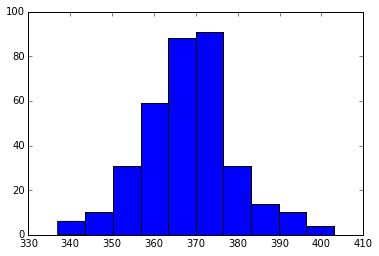

In [60]:
plt.hist([len(item) for item in rep])

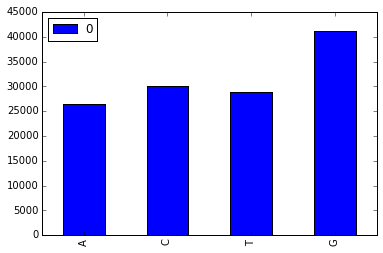

In [61]:
letter_counts = Counter(np.hstack(rep))
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

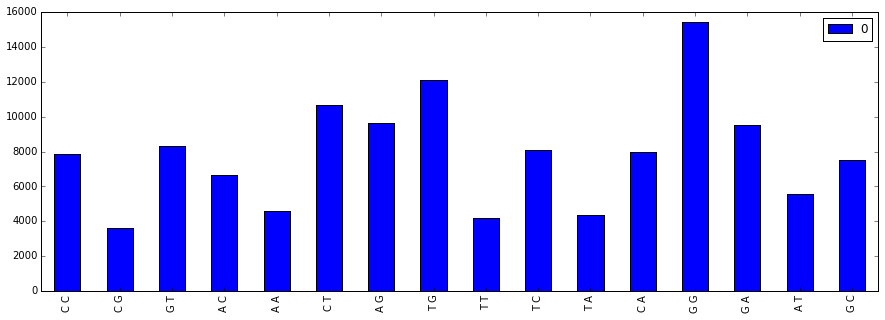

In [98]:
two_grams = map(lambda x: word_grams(x, min=2, max=3), rep)
build_letter_hist(two_grams, figsize=(15,5))

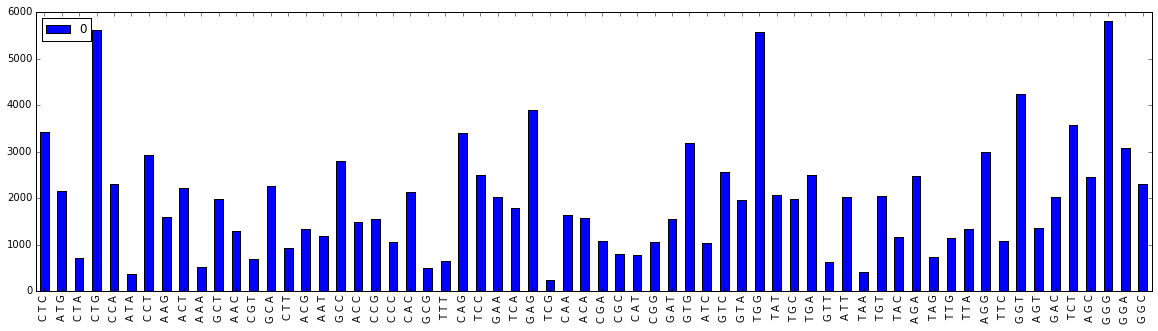

In [99]:
three_grams = map(lambda x: word_grams(x, min=3, max=4), rep)
build_letter_hist(three_grams, figsize=(20, 5))

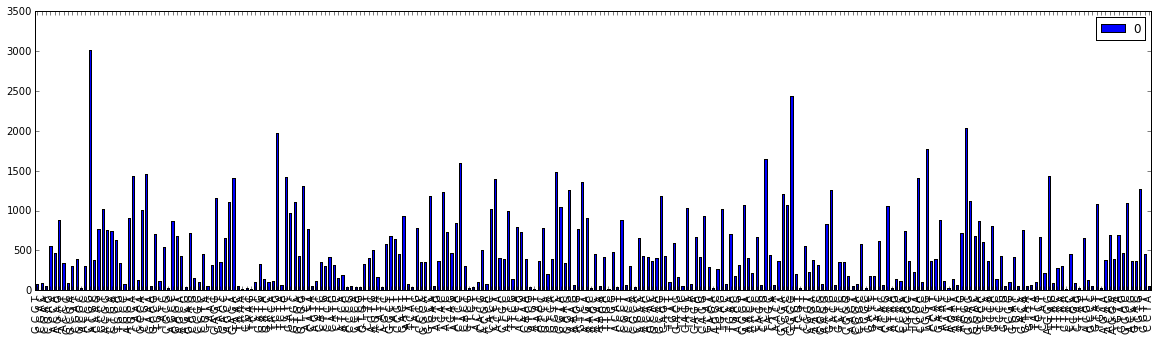

In [100]:
four_grams = map(lambda x: word_grams(x, min=4, max=5), rep)
build_letter_hist(four_grams, figsize=(20, 5))

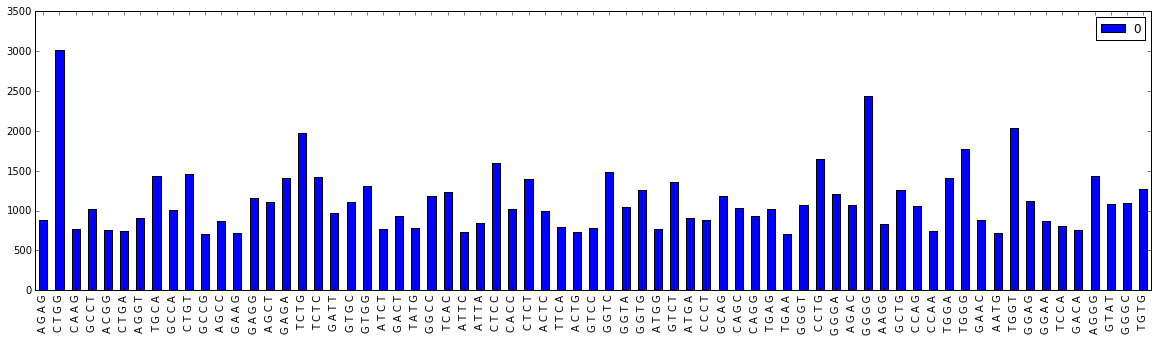

In [101]:
build_letter_hist(four_grams, figsize=(20, 5), threshold=700)

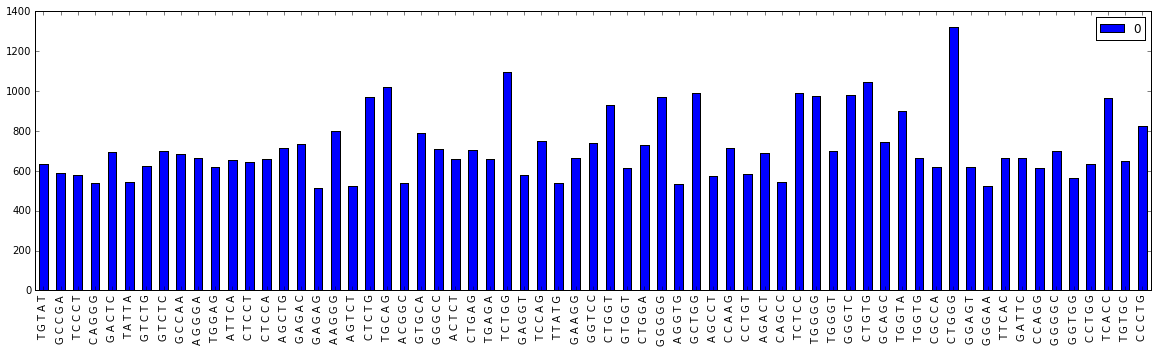

In [103]:
five_grams = map(lambda x: word_grams(x, min=5, max=6), rep)
build_letter_hist(five_grams, figsize=(20, 5), threshold=500)

Очень много 6-мер повторяются примерно одинаковое количество раз и есть не так много (20-30) 6-мер, которые под это правило не подходят 

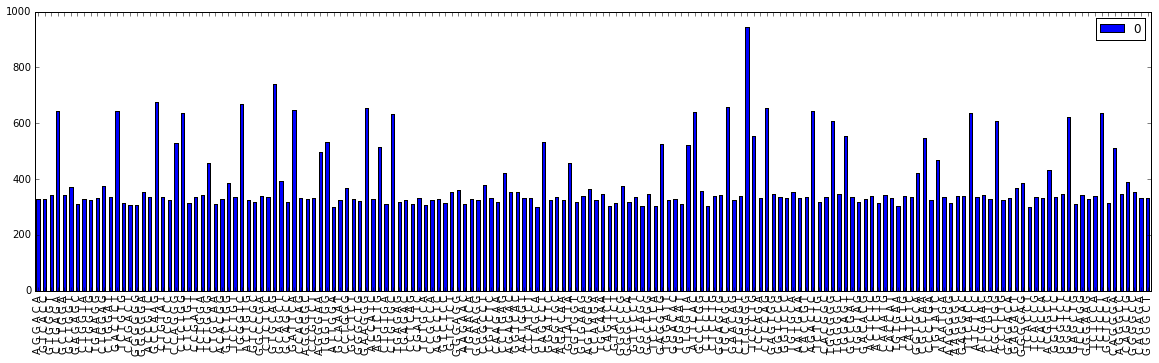

In [315]:
six_grams = map(lambda x: word_grams(x, min=6, max=7), rep)
build_letter_hist(six_grams, figsize=(20, 5), threshold=300)

In [141]:
seven_grams = map(lambda x: word_grams(x, min=7, max=8), rep)
build_letter_hist(seven_grams, figsize=(20, 5), threshold=300)

ERROR! Session/line number was not unique in database. History logging moved to new session 299


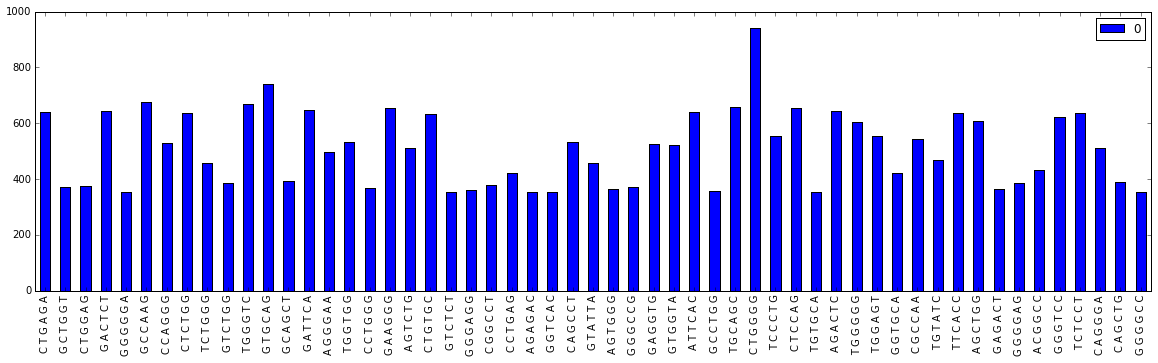

In [109]:
build_letter_hist(six_grams, figsize=(20, 5), threshold=350)

# INPUT 

In [10]:
# id_dict - dict with ids -> read
# rep - reference repertoire, array of reads
# rcm - reference repertoire, dict with ids -> cluster number
id_dict = id_to_read('input_reads.fa')
rep = read_repertoire('repertoire.fa')
rcm = read_rcm("repertoire.rcm")

In [11]:
# clusters - dict with ids -> array of read included in this cluster
clusters = construct_clusters(rcm, id_dict)

In [12]:
# final_rcm - final clusters description 
final_rcm = read_rcm('final_repertoire.rcm')

In [13]:
# dict with ids -> array of read included in this cluster
final_clusters = construct_clusters(final_rcm, id_dict)

In [14]:
# final_rep - final repertoire constructed by igrec
final_rep = clusters2rep(final_clusters)

In [15]:
# res - dict with second votes calculated for every position in cluster
# final_res - same as res calculated for igrec results 
res = second_votes(clusters)
final_res = second_votes(clusters_filtering(final_clusters))

In [ ]:
clf_f1 = clusters_classification(clusters, rep, final_rep)

In [ ]:
final_clf_sum_2 = clusters_classification(final_clusters, rep, final_rep)

In [ ]:
final_clf_sum = simple_clusters_classification(clusters_filtering(final_clusters), rep, final_rep)

Гистограмма для распределения second vote внутри одного из кластеров 

<Container object of 358 artists>

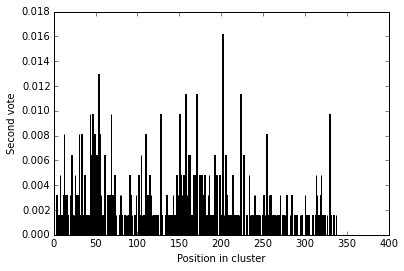

In [55]:
fig = plt.figure()
temp_dict = second_vote(clusters['4'])
temp_arr = [temp_dict[x] for x in range(len(clusters['4'][0]))]
plt.ylabel('Second vote')
plt.xlabel('Position in cluster')
plt.bar(range(len(clusters['4'][0])), temp_arr)
#fig.savefig('second_vote.pdf', format='pdf')

<Container object of 349 artists>

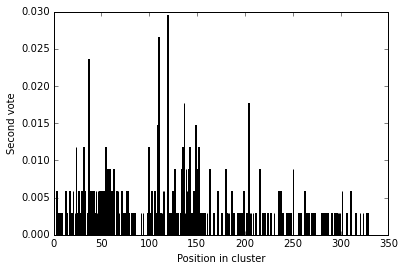

In [56]:
fig = plt.figure()
temp_dict = second_vote(clusters['11'])
temp_arr = [temp_dict[x] for x in range(len(clusters['11'][0]))]
plt.ylabel('Second vote')
plt.xlabel('Position in cluster')
plt.bar(range(len(clusters['11'][0])), temp_arr)
#fig.savefig('second_vote.pdf', format='pdf')

Гистограмма для распределения для second vote 
Видно, что много кластеров имеют second vote ~ 0.5

(0, 0.6)

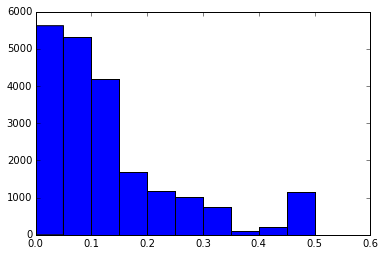

In [97]:
res1 = []
for key in res:
    res1.append(np.max(res[key].values()) if len(res[key].values()) else 0)
plt.hist(res1)
plt.xlim((0, 0.6))

<Container object of 500 artists>

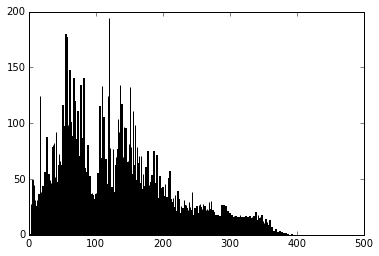

In [16]:
res1 = [0]*500
for key in range(21200):
    for i in range(500):
        if res_dict[str(key)][i] > 0.05:
            res1[i] += res_dict[str(key)][i]
plt.bar(range(500), res1)

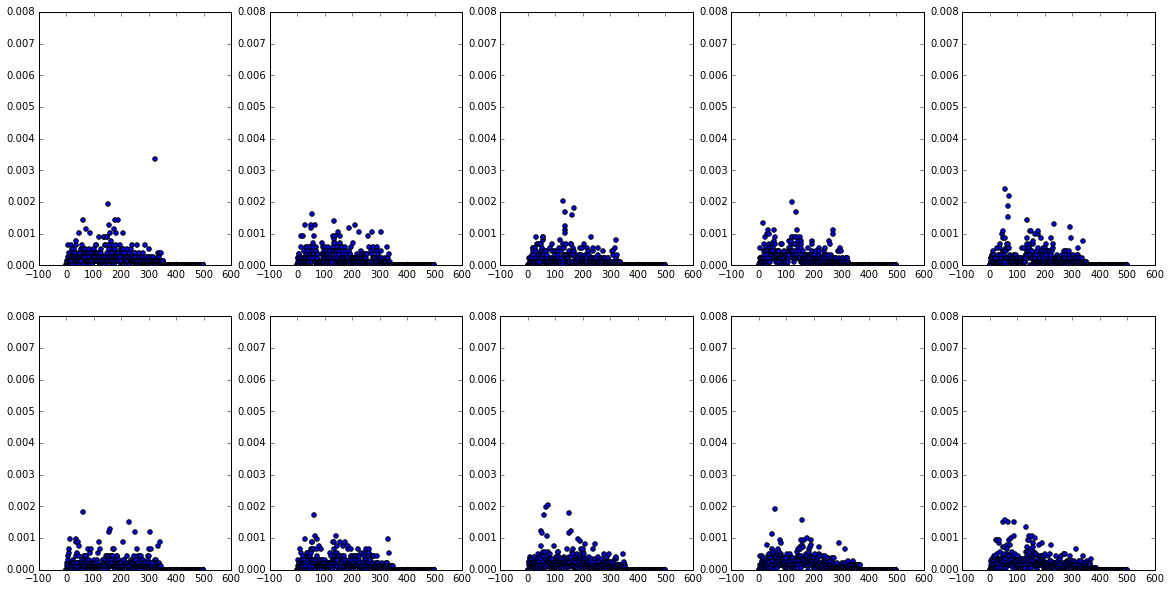

In [32]:
top_10 = top_massive_clusters(clusters, 10)

<Container object of 500 artists>

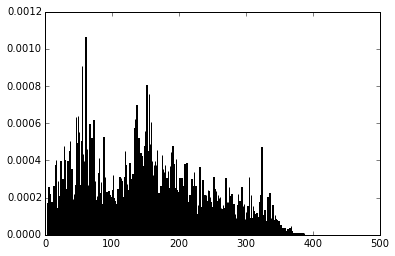

In [54]:
plt.bar(range(500), np.mean(top_10, axis=0))

In [49]:
max_second_vote = {key:(np.max(res[key].values()) if len(res[key].values()) else 0) for key in res}

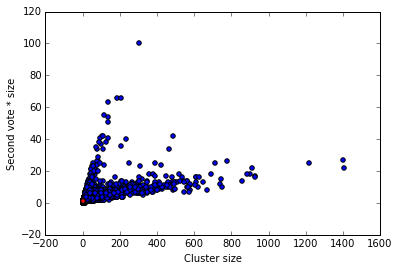

In [88]:
dots = [] 
sizes = clusters_size_dict(clusters)
for key in sizes:
    dots.append((sizes[key], sizes[key]*max_second_vote[key], clf_f1[key]))
plt.scatter([x[0] for x in dots if x[2] == -1], [x[1] for x in dots if x[2] == -1], c='b')
plt.scatter([x[0] for x in dots if x[2] == 0], [x[1] for x in dots if x[2] == 0], c='k')
plt.scatter([x[0] for x in dots if x[2] == 1], [x[1] for x in dots if x[2] == 1], c='r')
plt.ylabel("Second vote * size")
plt.xlabel("Cluster size")

(0, 10)

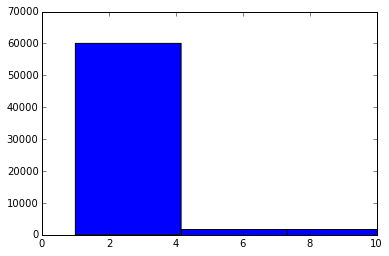

In [103]:
plt.hist(clusters_size_dict(final_clusters).values(), bins=400)
plt.xlim((0, 10))

In [30]:
major_vote(final_clusters['1'])

'CAGCTGCAGCTGCAGGAGTCGGGCCCAGGCCTAGTGAAGCCTTCGGAGACCCTCTCCCTCACCTGCAATGTCTCCGGTGACTCCGTCAGCGGTAGTTTTTACTCCTGGGCCTGGATACGACAGTCCCCAGGGAGGGGACTGGAGTGGATTGGAAGTGTCTCTTCCAGTAGGACCCCTTACTACAACCCGTCTTTCAAAAGTCAAGTCAGCATATCCAGAGACACGTCCAAGAACCAATTCACCCTGCAGTTGACCGCTGTGACCGCCGCGGACATGGCCGTTTATTATTGTGCGAGAGAGGGCGGGAGTTACCTCCTTAACTTCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG'

In [42]:
c = set()
for key in final_clusters:
    if len(final_clusters[key]) < 5 and major_vote(final_clusters[key]) in rep:
        c.add(major_vote(final_clusters[key]))

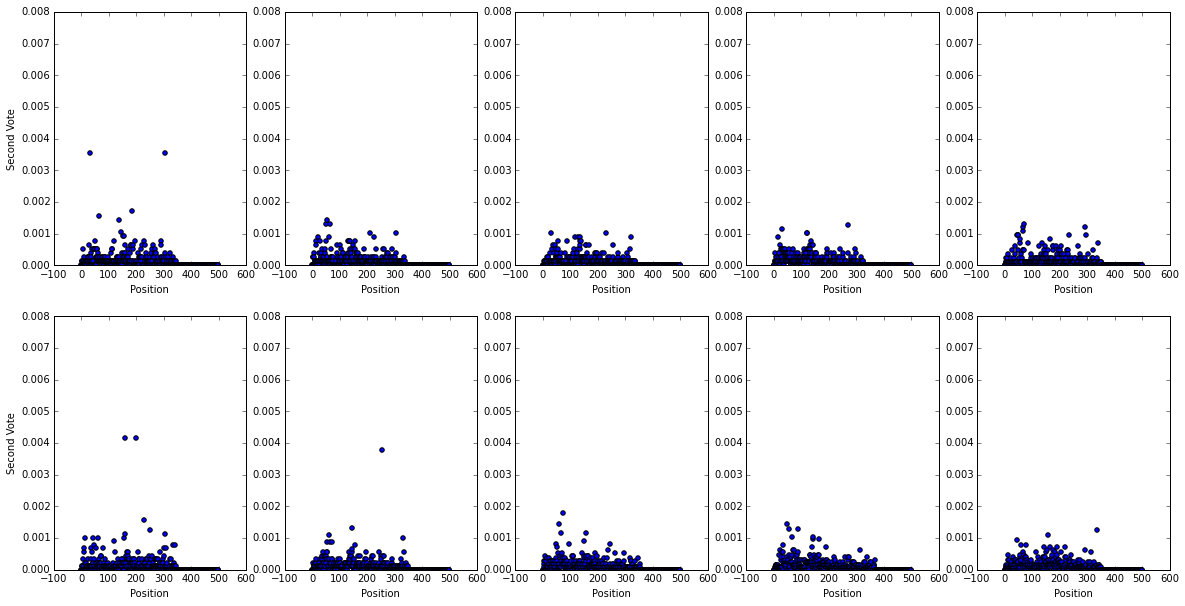

In [61]:
top_fin_10 = top_massive_clusters(final_clusters, final_res)

<Container object of 500 artists>

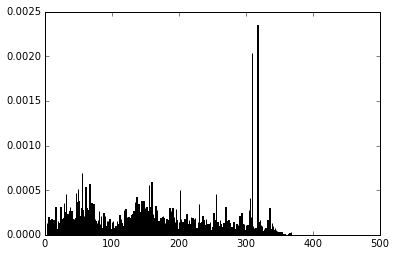

In [62]:
plt.bar(range(500), np.mean(top_fin_10, axis=0))

In [67]:
max_final_second_vote = {key:(np.max(final_res[key].values()) if len(final_res[key].values()) else 0) for key in final_res}

10

In [ ]:
dots = [] 
sizes = clusters_size_dict(clusters_filtering(final_clusters))
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
for key in sizes:
    dots.append((sizes[key], sizes[key]*max_final_second_vote[key], final_clf_sum[key]))
axes[0].scatter([x[0] for x in dots if x[2] == -1], [x[1] for x in dots if x[2] == -1], c='b', label='Quality decreased')
axes[0].scatter([x[0] for x in dots if x[2] == 0], [x[1] for x in dots if x[2] == 0], c='k')
axes[0].scatter([x[0] for x in dots if x[2] == 1], [x[1] for x in dots if x[2] == 1], c='r', label='Quality increased')

classifier = Lasso()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2]) 
axes[0].plot(range(1000),np.poly1d(classifier.coef_)(range(1000)))

classifier = SGDClassifier()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2]) 
for coef_ in classifier.coef_:
    axes[0].plot(range(1000),np.poly1d(coef_)(range(1000)))

axes[0].legend()
axes[0].set_xlim((-1, 1300))
axes[0].set_ylim((-1, 200))
axes[0].set_ylabel("Second vote * size")
axes[0].set_xlabel("Cluster size")

axes[1].hist(final_clf_sum.values())

fig.savefig('graph.pdf', format='pdf')

In [9]:
import func_tools
reload(func_tools)
from func_tools import *

In [24]:
r = simple_clusters_classification(clusters_filtering(final_clusters, threshold=50), rep)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [25]:
max_final_second_vote = {key:(np.max(final_res[key].values()) if len(final_res[key].values()) else 0) for key in final_res}

(array([ 1379.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   180.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

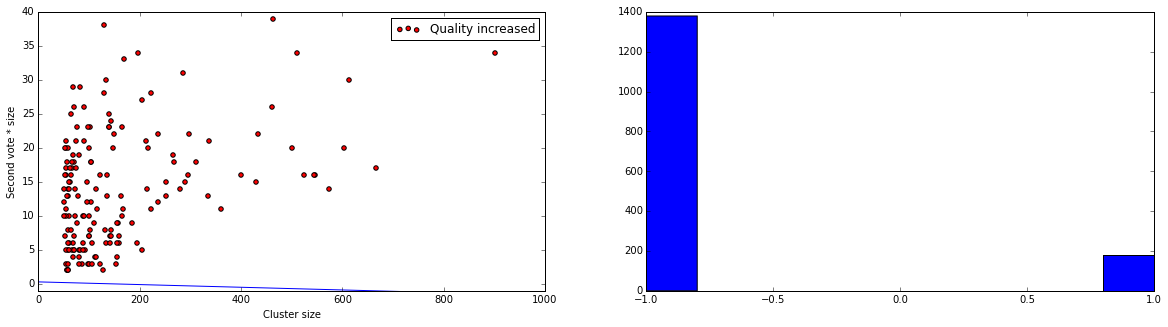

In [87]:
dots = [] 
sizes = clusters_size_dict(clusters_filtering(final_clusters, threshold=50))
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
for key in sizes:
    dots.append((sizes[key], sizes[key]*max_final_second_vote[key], r[key]))
#axes[0].scatter([x[0] for x in dots if x[2] == -1], [x[1] for x in dots if x[2] == -1], c='b', label='Quality decreased')
axes[0].scatter([x[0] for x in dots if x[2] == 0], [x[1] for x in dots if x[2] == 0], c='k')
axes[0].scatter([x[0] for x in dots if x[2] == 1], [x[1] for x in dots if x[2] == 1], c='r', label='Quality increased')

classifier = LogisticRegression()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2]) 
axes[0].plot(range(1000),np.poly1d(classifier.coef_[0])(range(1000)))

axes[0].legend()
axes[0].set_xlim((-1, 1000))
axes[0].set_ylim((-1, 40))
axes[0].set_ylabel("Second vote * size")
axes[0].set_xlabel("Cluster size")

axes[1].hist(r.values())

In [88]:
np.array(dots)[:,[0,1]],  np.array(dots)[:,2]

(array([[ 157.,    7.],
        [  73.,    5.],
        [ 188.,    3.],
        ..., 
        [ 359.,    7.],
        [  54.,    3.],
        [  59.,    2.]]), array([-1., -1., -1., ..., -1., -1.,  1.]))

In [93]:
classifier = LogisticRegression()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2]) 
pred = classifier.predict(np.array(dots)[:,[0,1]])

plt.scatter([x[0] for x in dots if pred == -1], [x[1] for x in dots if pred == -1], c='b', label='Quality decreased')
plt.scatter([x[0] for x in dots if pred == 1], [x[1] for x in dots if pred == 1], c='r', label='Quality increased')

plt.plot(range(1000),np.poly1d(classifier.coef_[0])(range(1000)))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [92]:
plt.scatter()

Counter({-1.0: 1453, 1.0: 106})